In [1]:
import os, pathlib, numpy as np, tensorflow as tf

In [2]:
SEED=42
DATASET_PATH="./dataset"

In [3]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
data_dir = pathlib.Path(DATASET_PATH)

commands = tf.io.gfile.listdir(str(data_dir))

print(commands)

['follow', 'learn', 'tree', 'visual']


In [30]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
  directory=DATASET_PATH,
  output_sequence_length=16000,
  batch_size=64,
  subset='both',
  seed=SEED,
  validation_split=0.3
)

label_names = train_ds.class_names
num_labels = len(label_names)

Found 6505 files belonging to 4 classes.
Using 4554 files for training.
Using 1951 files for validation.


In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

In [7]:
squeezed_train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
squeezed_val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

squeezed_val_ds = squeezed_val_ds.shard(num_shards=2, index=0)
squeezed_test_ds = squeezed_val_ds.shard(num_shards=2, index=1)

In [8]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
    waveform,
    frame_length=255,
    frame_step=128,
  )

  spectrogram = tf.abs(spectrogram)[..., tf.newaxis]

  return spectrogram

In [9]:
def make_spec_ds(ds):
  return ds.map(
    map_func=lambda audio, label: (get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
  )

In [10]:
train_spec_ds = make_spec_ds(squeezed_train_ds)
val_spec_ds = make_spec_ds(squeezed_val_ds)
test_spec_ds = make_spec_ds(squeezed_test_ds)

In [20]:
for example_spectrograms, example_spectlabels in train_spec_ds.take(1):
  break

cached_train_ds = train_spec_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
cached_val_ds = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
cached_test_ds = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print(f"Input shape: {input_shape}")
print(f"Num Labels: {num_labels}")

Input shape: (124, 129, 1)
Num Labels: 4


In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [15]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=cached_train_ds.map(map_func=lambda spec, _: spec))

In [23]:
model = models.Sequential([
  layers.Input(shape=input_shape),
  layers.Resizing(32, 32),
  norm_layer,
  layers.Conv2D(32, 3, activation="relu"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation="relu"),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(num_labels),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,375 (1.20 MB)

 Trainable params: 314,372 (1.20 MB)

 Non-trainable params: 3 (16.00 B)

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.AdamW(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
)

In [26]:
EPOCHS=10
history = model.fit(
  cached_train_ds,
  validation_data=cached_val_ds,
  epochs=EPOCHS,
  callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5170 - loss: 1.1033 - val_accuracy: 0.7548 - val_loss: 0.6349
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7755 - loss: 0.6161 - val_accuracy: 0.8789 - val_loss: 0.4278
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8435 - loss: 0.4416 - val_accuracy: 0.9011 - val_loss: 0.3445
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8808 - loss: 0.3541 - val_accuracy: 0.9122 - val_loss: 0.2918
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9069 - loss: 0.2903 - val_accuracy: 0.9162 - val_loss: 0.2698
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9048 - loss: 0.2724 - val_accuracy: 0.9051 - val_loss: 0.2623
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9113 - loss: 0.2451 - val_accuracy: 0.9253 - val_loss: 0.2232
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9277 - loss: 0.2184 - val_accuracy: 0.9395 - val_loss

[]

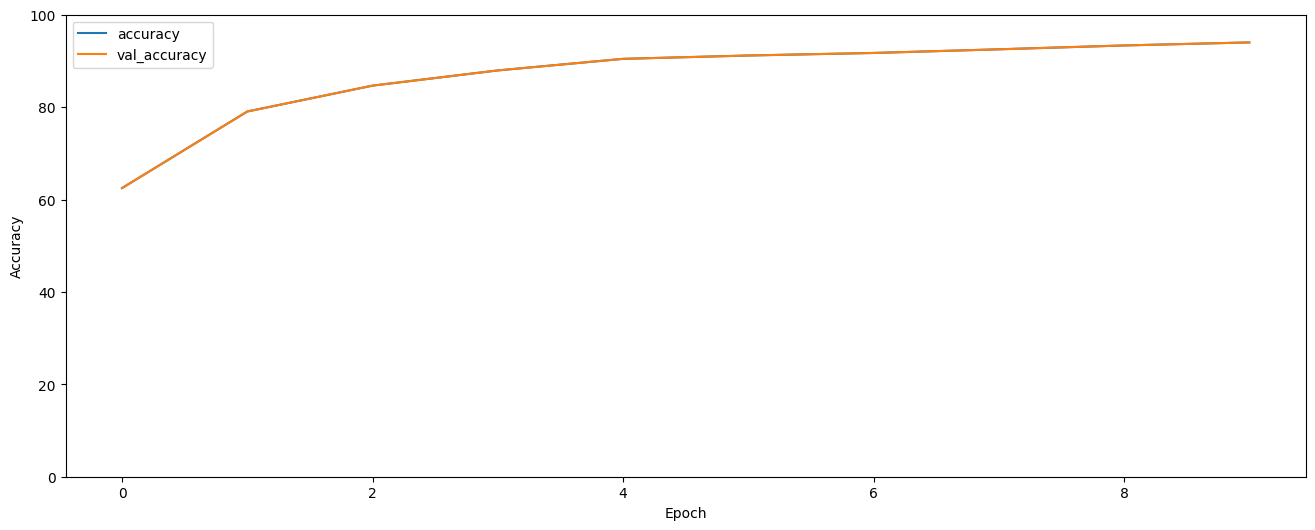

In [27]:
import matplotlib.pyplot as plt
metrics = history.history

plt.figure(figsize=(16, 6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot()

In [28]:
test_results = model.evaluate(cached_test_ds, return_dict=True)
accuracy = test_results['accuracy']
print(f'Test accuracy: {accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9303 - loss: 0.2251
Test accuracy: 0.9415448904037476


In [36]:
idx = 0
for i, (spectrogram, label) in enumerate(test_spec_ds):
  pred = model.predict(spectrogram)
  pred_label_idx = tf.argmax(pred, axis=1).numpy()
  orig_label = [label_names[idx] for idx in label]
  pred_label = [label_names[idx] for idx in pred_label_idx]

  for j, label in enumerate(orig_label):
    idx += 1
    print(f"Data {idx}: Original label -> {label}, Prediction -> {pred_label[j]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Data 1: Original label -> visual, Prediction -> visual
Data 2: Original label -> tree, Prediction -> tree
Data 3: Original label -> learn, Prediction -> learn
Data 4: Original label -> tree, Prediction -> tree
Data 5: Original label -> follow, Prediction -> follow
Data 6: Original label -> visual, Prediction -> visual
Data 7: Original label -> follow, Prediction -> follow
Data 8: Original label -> tree, Prediction -> tree
Data 9: Original label -> visual, Prediction -> visual
Data 10: Original label -> visual, Prediction -> visual
Data 11: Original label -> visual, Prediction -> visual
Data 12: Original label -> follow, Prediction -> follow
Data 13: Original label -> follow, Prediction -> follow
Data 14: Original label -> learn, Prediction -> learn
Data 15: Original label -> learn, Prediction -> learn
Data 16: Original label -> follow, Prediction -> follow
Data 17: Original label -> visual, Prediction -> learn
Data 18: Original label -> follow, Pre